In [1]:
#functoinalities 
import os
from itertools import chain 
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

#analytics
import numpy as np
import pandas as pd

#plotting
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

#network 
import networkx as nx
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Polygon

## Driving times 

In [2]:
df = pd.read_csv("../data/experiment/all_scenarios.csv").drop(columns=['Unnamed: 0'])
df.head()

,prob_A,prob_B,prob_C,prob_D,Run,Average driving time,Probs,Worst bridge delay,Worst bridge name
0,0.0,0.0,0.0,0.0,0,387.226003,"{'A': 0, 'B': 0, 'C': 0, 'D': 0}",0.0,bridge at id 1004
1,0.0,0.0,0.0,0.0,1,387.441454,"{'A': 0, 'B': 0, 'C': 0, 'D': 0}",0.0,bridge at id 1004
2,0.0,0.0,0.0,0.0,2,387.489698,"{'A': 0, 'B': 0, 'C': 0, 'D': 0}",0.0,bridge at id 1004
3,0.0,0.0,0.0,0.0,3,387.238692,"{'A': 0, 'B': 0, 'C': 0, 'D': 0}",0.0,bridge at id 1004
4,0.0,0.0,0.0,0.0,4,385.501432,"{'A': 0, 'B': 0, 'C': 0, 'D': 0}",0.0,bridge at id 1004


In [3]:
rows = []
xlist = [0, 10, 20, 30, 40]

for scenario, start in enumerate(xlist):
    s = df.iloc[start:start+10]["Average driving time"]
    ave, maxx, minn = s.mean(), s.max(), s.min()

    # keep your original semantics (min_fill holds maxx; max_fill holds minn)
    rows.append({"Scenario": scenario, "Variable": "Average driving time", "Time": maxx})  # min_fill
    rows.append({"Scenario": scenario, "Variable": "Average driving time", "Time": ave})   # dfAve
    rows.append({"Scenario": scenario, "Variable": "Average driving time", "Time": minn})  # max_fill

df_result = pd.DataFrame(rows, columns=["Scenario", "Variable", "Time"])

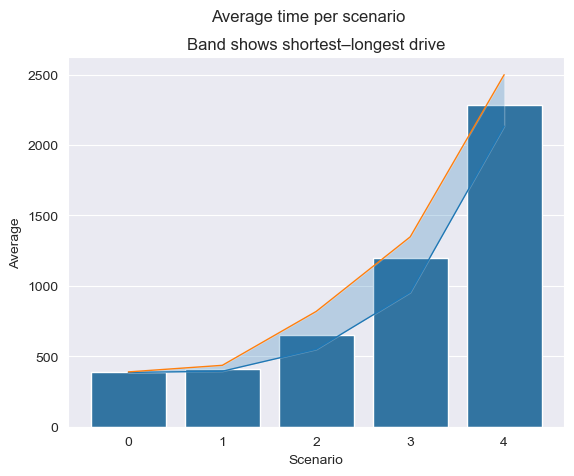

In [4]:
# --- build a clean plotting frame with avg/min/max per scenario ---
rows = []
for scenario, start in enumerate([0,10,20,30,40]):
    s = df.iloc[start:start+10]["Average driving time"]
    rows += [
        (scenario, "Average", s.mean()),
        (scenario, "Minimum", s.min()),
        (scenario, "Maximum", s.max()),
    ]
df_result = pd.DataFrame(rows, columns=["Scenario","Variable","Time"])

# --- bar of averages ---
import seaborn as sns, matplotlib.pyplot as plt
sns.set_style('darkgrid')

wide = df_result.pivot(index="Scenario", columns="Variable", values="Time").sort_index()

ax = sns.barplot(
    x=wide.index, y=wide["Average"], color="C0", errorbar=None   # no hue, avoid palette issue
)

# --- add min–max band and lines ---
ax.fill_between(wide.index, wide["Minimum"], wide["Maximum"], alpha=0.25)
ax.plot(wide.index, wide["Minimum"], linewidth=1)
ax.plot(wide.index, wide["Maximum"], linewidth=1)

plt.suptitle('Average time per scenario')
plt.title('Band shows shortest–longest drive')
plt.savefig('driving_time.png', dpi=200, bbox_inches='tight')
plt.show()

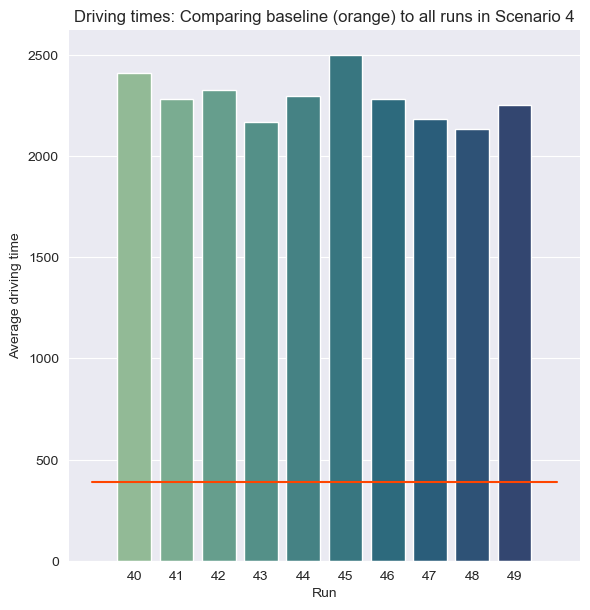

In [5]:
g = sns.catplot(
    data=df.tail(10), kind="bar",
    x="Run", y="Average driving time", errorbar="sd", palette="crest", alpha=1, height=6)
g.despine(left=True)
g.set_axis_labels("Run", "Average driving time")
sns.lineplot(x = [-1,10], y=387.251584, color='orangered')
plt.title('Driving times: Comparing baseline (orange) to all runs in Scenario 4')
plt.savefig('scenarios_one_eight.png')

## Delay Time 

In [6]:
df_delay = pd.read_csv("../data/experiment/all_scenarios.csv").drop(columns=['Unnamed: 0','prob_A','prob_B','prob_C','prob_D','Run','Probs'])

In [7]:
scenario = list([[i]*10 for i in range(0,5)])
scenario = list(chain.from_iterable(scenario))
df_delay['Scenario'] = scenario

In [8]:
df_delay = df_delay.rename(columns={'Worst bridge delay':'delay time'})

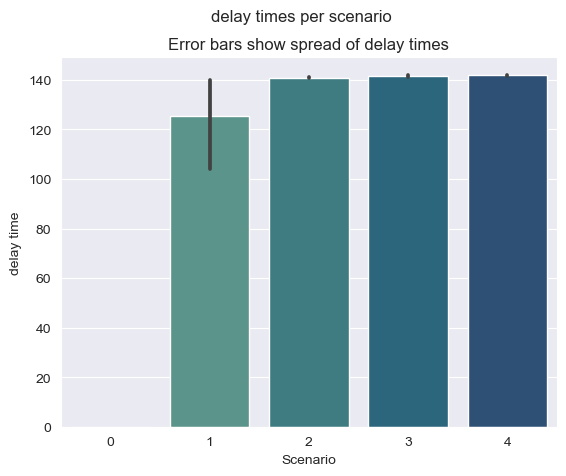

In [9]:
sns.barplot(x='Scenario',y='delay time', data=df_delay, palette='crest');
plt.suptitle('delay times per scenario')
plt.title('Error bars show spread of delay times')
plt.savefig('delay_time.png')

## Bridges

In [10]:
df = pd.read_csv("../data/experiment/all_scenarios.csv").drop(columns=['Unnamed: 0'])
df_sorted = df.sort_values(by = "Worst bridge delay", ascending=False).drop_duplicates(subset = 'Worst bridge name')
df_sorted.shape

(36, 9)

In [11]:
df_bridge_count = df[df["Worst bridge delay"] != 0]
df_bridge_count = df_bridge_count['Worst bridge name'].value_counts()
df_bridge_count

Worst bridge name
NORTH NAGDA SLAB CULVERT        2
SHOMO PUR BOX CULVERT           2
SHATORA RCC GIDER BRIDGE        2
OKYIA STATION                   2
MANDAR GRAM BOX CULVERT         2
NABAKALASH                      1
LAXMISORA BRIDGE                1
PACH GORIA SLAB CULVERT         1
POLARGHAT BAZAR BRIDGE          1
ROJUBPUR BRIDGE BOX CULVERT     1
SHANTIR HAT                     1
UKLIA-SHAHABMARKAT              1
Kutalpur Bridge                 1
Mokam Bazar Box Culvert         1
MONU PC GIRDER BRIDGE           1
KAKUM TOLI CHACK BOX CULVERT    1
Elaspur steal deck              1
JAMALPUR                        1
KORER HAT BAZER                 1
DARMACHPUR CULVERT              1
BALU KHALI -2 BOX CULVERT       1
KALIBARI RCC GIDER BRIDGE       1
PALONG KHALI BAZAR BRIDGE       1
PRAIL GRAM BRIDGE               1
KANORAM SLAB CULVERT            1
ALAMDARPARA BOX CULVERT         1
TOWN HALL MORE CULVERT          1
BARIPOLE BOX                    1
BOLG BAILEY WITH STEEL DECK   

In [12]:
G = nx.Graph()
df = pd.read_csv("../data/processed/N1_N2_plus_sideroads.csv")
df.head()

,road,id,model_type,condition,name,lat,lon,length,bridge_name
0,N1,1000,sourcesink,NaN,SoSi1,23.706028,90.443333,0.0,NaN
1,N1,1001,link,NaN,NaN,23.702917,90.450417,814.0,NaN
2,N1,1002,link,NaN,NaN,23.702778,90.450472,8.0,NaN
3,N1,1003,link,NaN,NaN,23.702139,90.451972,178.0,NaN
4,N1,1004,bridge,A,NaN,23.698739,90.458861,11.3,bridge at id 1004


In [13]:
for i in range(len(df)):
    G.add_node(df['id'][i], road=df['road'][i], length=df['length'][i], pos = [df['lon'][i],df['lat'][i]])

In [14]:
intersection = df.loc[df['model_type'] == 'intersection']
intersection = intersection.reset_index().drop(columns=['index'])
sourcesinks = df.loc[df['model_type'] == "sourcesink"]
sourcesinks = sourcesinks.reset_index()
sourcesinks.head()

,index,road,id,model_type,condition,name,lat,lon,length,bridge_name
0,0,N1,1000,sourcesink,NaN,SoSi1,23.706028,90.443333,0.0,NaN
1,1781,N102,2782,sourcesink,NaN,SoSi2,24.050611,91.114667,549.0,NaN
2,1912,N104,2913,sourcesink,NaN,SoSi3,22.825749,91.101444,120.0,NaN
3,2875,N2,3995,sourcesink,NaN,SoSi4,25.157056,92.017638,256.0,NaN
4,3167,N207,4289,sourcesink,NaN,SoSi5,24.626333,91.677527,350.0,NaN


In [15]:
intersection

,road,id,model_type,condition,name,lat,lon,length,bridge_name
0,N1,6015,intersection,NaN,NaN,23.930027,90.452583,260.0,NaN
1,N1,1133,intersection,NaN,NaN,23.530805,90.781110,815.0,NaN
2,N1,1157,intersection,NaN,NaN,23.513111,90.870638,42.0,NaN
3,N1,1158,intersection,NaN,NaN,23.512667,90.871416,102.0,NaN
4,N1,1209,intersection,NaN,NaN,23.478972,91.117999,28.0,NaN
...,...,...,...,...,...,...,...,...,...
82,Z1065,7716,intersection,NaN,NaN,22.374638,91.906278,200.0,NaN
83,Z1065,7716,intersection,NaN,NaN,22.374638,91.906278,20.0,NaN
84,Z1098,2554,intersection,NaN,NaN,20.862917,92.298083,405.0,NaN
85,Z1402,1133,intersection,NaN,NaN,23.530805,90.781110,577.0,NaN


In [16]:
previousnode = -1

for i,row in df.iterrows():
    if previousnode != -1:
        if row['road'] == df.iloc[previousnode,0]:
            G.add_edge(df.iloc[previousnode,1], row['id'], weight=row['length'])
    previousnode = i
pos = nx.get_node_attributes(G,'pos')


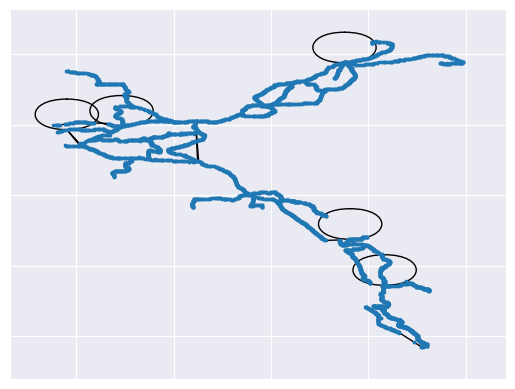

In [17]:
nx.draw_networkx(G, pos = pos, node_size = 4,node_shape='s',with_labels=False)

In [18]:
#The appearance of the circles was unexpected and there was nothing we could find in the literature that may be able to 
#explian why those circles were appearing and what could be done about them. 
nx.write_edgelist(G,'../data/processed/NetworkG.edgelist') 
nx.write_edgelist(G,'../data/processed/NetworkG.csv',delimiter=',') 

In [19]:
shortestpath_dict = {}

def find_shortest_path(graph, a,b):
    if (a,b) in shortestpath_dict:
        p = shortestpath_dict[(a,b)]
    else:
        p = nx.shortest_path(graph, source=a, target=b, weight = 'weight')
        shortestpath_dict.update({(a,b):p})
    return p

In [20]:
sourcesinks


,index,road,id,model_type,condition,name,lat,lon,length,bridge_name
0,0,N1,1000,sourcesink,NaN,SoSi1,23.706028,90.443333,0.0,NaN
1,1781,N102,2782,sourcesink,NaN,SoSi2,24.050611,91.114667,549.0,NaN
2,1912,N104,2913,sourcesink,NaN,SoSi3,22.825749,91.101444,120.0,NaN
3,2875,N2,3995,sourcesink,NaN,SoSi4,25.157056,92.017638,256.0,NaN
4,3167,N207,4289,sourcesink,NaN,SoSi5,24.626333,91.677527,350.0,NaN
5,3539,R151,4688,sourcesink,NaN,SoSi6,22.708222,91.784083,80.0,NaN
6,3801,R170,4950,sourcesink,NaN,SoSi7,21.752167,92.007833,67.0,NaN
7,4309,R240,5647,sourcesink,NaN,SoSi9,24.593805,91.610472,1250.0,NaN
8,4310,R250,5771,sourcesink,NaN,SoSi12,24.886000,91.868138,0.0,NaN
9,4540,R250,6001,sourcesink,NaN,SoSi13,24.873138,92.365028,315.0,NaN


In [21]:
find_shortest_path(G,6002,6083)

[6002,
 6003,
 6004,
 6005,
 6006,
 6007,
 6008,
 6009,
 6010,
 6011,
 6012,
 6013,
 6014,
 6015,
 6017,
 6018,
 6019,
 6020,
 6021,
 6022,
 6023,
 6024,
 6025,
 6026,
 6027,
 6028,
 6029,
 6030,
 6031,
 6032,
 6033,
 6034,
 6035,
 6036,
 6037,
 6038,
 6039,
 6040,
 6041,
 6042,
 6043,
 6044,
 6045,
 6046,
 6047,
 6048,
 6049,
 6050,
 6051,
 6052,
 6053,
 6054,
 6055,
 6056,
 6057,
 6058,
 6059,
 6060,
 6061,
 6062,
 6063,
 6064,
 6065,
 6066,
 6067,
 6068,
 6069,
 6070,
 6071,
 6072,
 6073,
 6074,
 6075,
 6076,
 6077,
 6078,
 6079,
 6080,
 6081,
 3097,
 3098,
 3099,
 3100,
 3101,
 3102,
 3103,
 3104,
 3105,
 3106,
 3107,
 3108,
 3109,
 3110,
 3111,
 3112,
 3113,
 3114,
 3115,
 3116,
 3117,
 3118,
 3119,
 3120,
 3121,
 3122,
 3123,
 3124,
 3125,
 3126,
 3127,
 3128,
 3129,
 3130,
 3131,
 3132,
 3133,
 3134,
 3135,
 3136,
 3137,
 3138,
 3139,
 3140,
 3141,
 6175,
 6174,
 6173,
 6172,
 6171,
 6170,
 6169,
 6168,
 6167,
 6166,
 6165,
 6164,
 6163,
 6162,
 6161,
 6160,
 6159,
 6158,
 6157,

In [22]:
found = 0
not_found = 0
for i, row in sourcesinks.iterrows():
    for j in range(1,len(sourcesinks)):
        try:
            find_shortest_path(G,row['id'],sourcesinks.iloc[j,2])
            #print("found path between",row['road'], "and", sourcesinks.iloc[j,1])
            found +=1
        except:
            print("could not find a path between",row['road'], "and", sourcesinks.iloc[j,1])
            not_found +=1
print(not_found/found*100,"percent of the paths could not be found")

0.0 percent of the paths could not be found


#### Run NetworkAnalysis.py BEFORE proceeding past this step

In [23]:
bridgemetrics = pd.read_csv("../data/output/network_metrics.csv")
inters=pd.read_csv("../data/output/network_intersection_metrics.csv")

In [24]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [25]:
# Sort the degree dictionairy and show the ten nodes with the highest degrees
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print(d)

Top 10 nodes by degree:
(6015, 6)
(6956, 6)
(7716, 6)
(3141, 6)
(5776, 6)
(1950, 5)
(2756, 4)
(3478, 4)
(3679, 4)
(5786, 4)


In [26]:
test = nx.to_pandas_edgelist(G)
test.loc[test['source'] == test['target']]

,source,target,weight
21,6015,6015,102.0
712,7716,7716,20.0
970,1950,1950,28.0
2041,3141,3141,75.0
2741,5776,5776,42.0


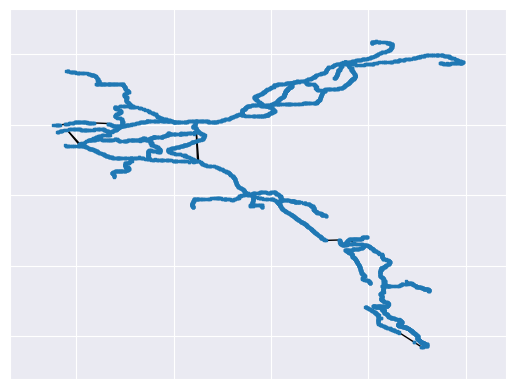

In [27]:
G.remove_edge(6015, 6015)
G.remove_edge(7716, 7716)
G.remove_edge(1950, 1950)
G.remove_edge(3141, 3141)
G.remove_edge(5776, 5776)

nx.draw_networkx(G, pos = pos, node_size = 4,node_shape='s',with_labels=False)

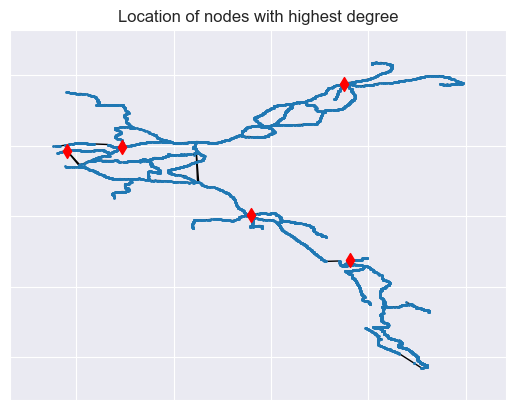

In [28]:
# Draw graph with highest degree hubs
Gsub = G.subgraph([6015,6956,7716,3141,5776])
nx.draw_networkx(G,pos, with_labels = False, node_size = 1)
nx.draw_networkx(Gsub,pos,node_color = 'red', node_shape = 'd', with_labels = False, node_size = 50)
plt.title('Location of nodes with highest degree')
plt.savefig('location.png')

In [29]:
df_between = bridgemetrics.sort_values('betweenness_centrality', ascending = False)
between = df_between.drop(df_between[df_between.betweenness_centrality < 0.45].index)
# Check
between.head(15)

,road,id,condition,bridge_name,betweenness_centrality,closeness_centrality,degreecentrality_centrality
65,N1,1213,A,AMTOLI SLAB CULVERT,0.485826,0.001788,0.000342
66,N1,1217,A,DHANPUR RCC GIDER BRIDGE,0.485594,0.001786,0.000342
67,N1,1229,B,PADUAR BAZER RCCGIDER,0.484886,0.001780,0.000342
68,N1,1231,C,Mostapur Bridge,0.484767,0.001779,0.000342
69,N1,1238,A,RAZAPARA RCC GIDER BRIDGE,0.484345,0.001775,0.000342
70,N1,1244,A,SUAGAZI RCC GIDER BRIDGE,0.483978,0.001771,0.000342
71,N1,1252,C,LAL BAG RCC GIDER BRIDGE,0.483483,0.001767,0.000342
72,N1,1254,A,CHANSIRI BOXCUIVERT,0.483358,0.001766,0.000342
73,N1,1264,A,MIABAZAR BOX CULVERT,0.482726,0.001760,0.000342
74,N1,1266,B,DOLL BARI CULVERT,0.482599,0.001759,0.000342


In [30]:
# Generate list based on df, for drawing the graph
b_list = []
b_list = between['id']

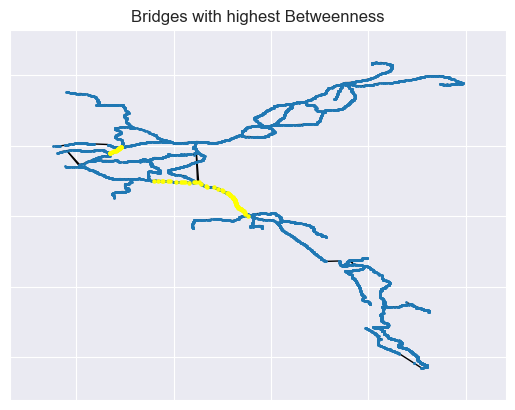

In [31]:
# Draw graph with betweenness areas, using the list based on threshold > 0.45
Gsub = G.subgraph(b_list)
nx.draw_networkx(G,pos, with_labels = False, node_size = 1)
nx.draw_networkx(Gsub,pos,node_color = 'yellow', with_labels = False, node_size = 5)
plt.title('Bridges with highest Betweenness')
plt.savefig('Between.png')

In [32]:
# Check the count of the conditions of the 'high betweenness centrality' - bridges
between['condition'].value_counts()

condition
B    41
A    40
C     7
Name: count, dtype: int64

In [33]:
intersection.head()

,road,id,model_type,condition,name,lat,lon,length,bridge_name
0,N1,6015,intersection,NaN,NaN,23.930027,90.452583,260.0,NaN
1,N1,1133,intersection,NaN,NaN,23.530805,90.781110,815.0,NaN
2,N1,1157,intersection,NaN,NaN,23.513111,90.870638,42.0,NaN
3,N1,1158,intersection,NaN,NaN,23.512667,90.871416,102.0,NaN
4,N1,1209,intersection,NaN,NaN,23.478972,91.117999,28.0,NaN


In [34]:
inters_between = inters.sort_values('betweenness_centrality', ascending = False)
interbetween = inters_between.drop(inters_between[inters_between.betweenness_centrality < 0.45].index)
interbetween.head()

,road,id,condition,bridge_name,betweenness_centrality,closeness_centrality,degreecentrality_centrality
19,N102,2756,NaN,NaN,0.513072,0.001789,0.000684
6,N1,2756,NaN,NaN,0.513072,0.001789,0.000684
74,Z1031,6956,NaN,NaN,0.496662,0.001692,0.001027
76,Z1034,6956,NaN,NaN,0.496662,0.001692,0.001027
7,N1,6956,NaN,NaN,0.496662,0.001692,0.001027


## Let's now visualise spatially

In [35]:
df = pd.read_csv("../data/experiment/all_scenarios.csv")
dbf= gpd.read_file("../data/raw/roads.shp")
frame=pd.read_csv("../data/processed/N1_N2_plus_sideroads.csv")
dbf.head()

,geometry
0,"LINESTRING (90.42258 23.79758, 90.42238 23.798..."
1,"LINESTRING (90.41891 23.79768, 90.42034 23.798..."
2,"LINESTRING (90.41857 23.79918, 90.41941 23.799..."
3,"LINESTRING (90.41926 23.80001, 90.42059 23.800..."
4,"LINESTRING (90.42049 23.80098, 90.42088 23.801..."


<Axes: >

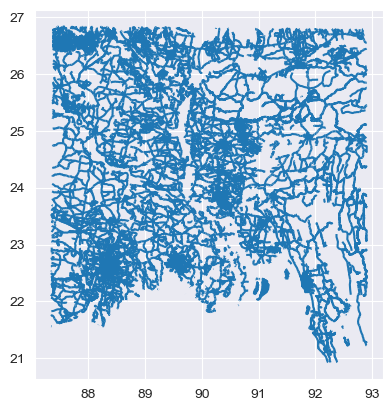

In [36]:
dbf.plot()

In [37]:
frame.head()

,road,id,model_type,condition,name,lat,lon,length,bridge_name
0,N1,1000,sourcesink,NaN,SoSi1,23.706028,90.443333,0.0,NaN
1,N1,1001,link,NaN,NaN,23.702917,90.450417,814.0,NaN
2,N1,1002,link,NaN,NaN,23.702778,90.450472,8.0,NaN
3,N1,1003,link,NaN,NaN,23.702139,90.451972,178.0,NaN
4,N1,1004,bridge,A,NaN,23.698739,90.458861,11.3,bridge at id 1004


In [38]:
latmin=frame['lat'].min()
latmax=frame['lat'].max()
lonmin=frame['lon'].min()
lonmax=frame['lon'].max()
print(latmin)
print(latmax)
print(lonmin)
print(lonmax)

20.8470274
25.1808604
90.381916
92.4850274


In [39]:
polyshape = gpd.GeoSeries(Polygon([(lonmin,latmin), (lonmin, latmax), (lonmax, latmax), (lonmax, latmin)]))

In [40]:
polydf = gpd.GeoDataFrame({'geometry': polyshape, 'df1':[1]})

<Axes: >

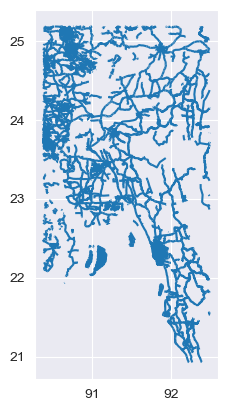

In [41]:
polydf.crs=dbf.crs
clipped_gdf = gpd.clip(dbf, polydf)
clipped_gdf=clipped_gdf['geometry']
clipped_gdf=clipped_gdf.reset_index(drop=True)
clipped_gdf.plot()

In [42]:
print(clipped_gdf.crs is None)
clipped_gdf = clipped_gdf.set_crs('epsg:9678',allow_override=True)
print(clipped_gdf.crs is None)

True
False


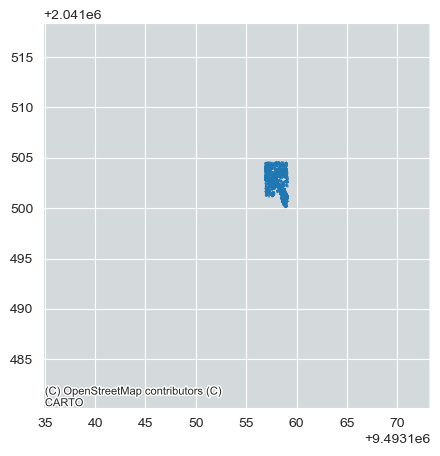

In [43]:
# Reproject to Web Mercator and use a live provider
w = clipped_gdf.to_crs(epsg=3857)
ax = w.plot(figsize=(5,5))
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=20)  # or OpenStreetMap.Mapnik
plt.axis('equal'); plt.show() 

In [44]:
df_model = pd.read_csv('../data/processed/N1_N2_plus_sideroads.csv')
df_geom= pd.read_csv('../data/processed/points_shapefile_new.csv') 

In [45]:
df_model = pd.read_csv('../data/processed/N1_N2_plus_sideroads.csv')
df_geom= pd.read_csv('../data/processed/points_shapefile_new.csv') 

In [46]:
df_intersect_model = df_model[df_model["model_type"] == "intersection"]

In [47]:
gdf_intersections = gpd.GeoDataFrame(
    df_intersect_model, geometry=gpd.points_from_xy(df_intersect_model.lon, df_intersect_model.lat))

In [48]:
gdf_intersections.head()

,road,id,model_type,condition,name,lat,lon,length,bridge_name,geometry
19,N1,6015,intersection,NaN,NaN,23.930027,90.452583,260.0,NaN,POINT (90.45258 23.93003)
133,N1,1133,intersection,NaN,NaN,23.530805,90.781110,815.0,NaN,POINT (90.78111 23.5308)
157,N1,1157,intersection,NaN,NaN,23.513111,90.870638,42.0,NaN,POINT (90.87064 23.51311)
158,N1,1158,intersection,NaN,NaN,23.512667,90.871416,102.0,NaN,POINT (90.87142 23.51267)
209,N1,1209,intersection,NaN,NaN,23.478972,91.117999,28.0,NaN,POINT (91.118 23.47897)


<Axes: >

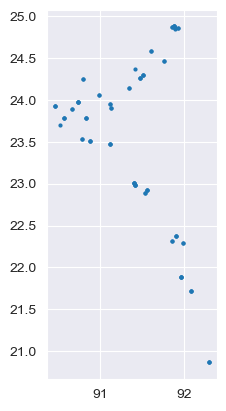

In [49]:
gdf_intersections.plot(markersize=4)

In [50]:
df_geom = df_geom.rename(columns = {'0':'lon', '1':'lat'})

In [51]:
df_geom.head()

,Unnamed: 0,lon,lat
0,0,92.194909,21.002732
1,1,92.266108,21.057847
2,2,92.266603,21.060217
3,3,92.142487,21.077862
4,4,92.197069,21.115806


In [52]:
def count_datatypes(df, col_name):
    dtypes_count = {}
    for _, value in df[col_name].items():  # <- iteritems() -> items()
        key = type(value).__name__ if pd.notna(value) else "NA"
        dtypes_count[key] = dtypes_count.get(key, 0) + 1
    return dtypes_count

print(count_datatypes(df_geom,'Unnamed: 0'))
print(count_datatypes(df_geom,'lon'))
print(count_datatypes(df_geom,'lat'))
print(df_geom.shape)

{'int': 29146}
{'float': 29146}
{'float': 29146}
(29146, 3)


In [53]:
gdf_real = gpd.GeoDataFrame(
    df_geom, geometry=gpd.points_from_xy(df_geom.lon, df_geom.lat))

gdf_real.head()

,Unnamed: 0,lon,lat,geometry
0,0,92.194909,21.002732,POINT (92.19491 21.00273)
1,1,92.266108,21.057847,POINT (92.26611 21.05785)
2,2,92.266603,21.060217,POINT (92.2666 21.06022)
3,3,92.142487,21.077862,POINT (92.14249 21.07786)
4,4,92.197069,21.115806,POINT (92.19707 21.11581)


<Axes: >

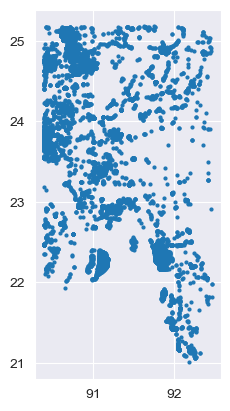

In [54]:
gdf_real.plot(markersize=4)

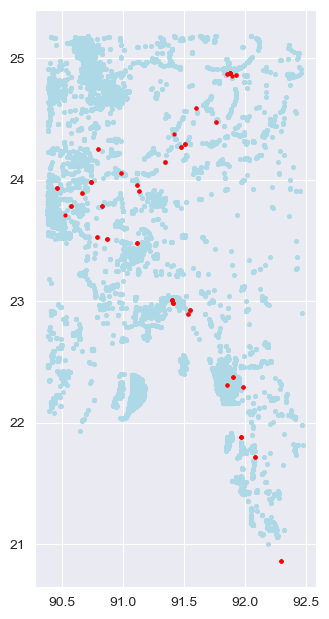

In [55]:
base = gdf_real.plot(color='lightblue', markersize = 7, figsize = (15,7.5))
gdf_intersections.plot(ax=base, marker='o', color='red', markersize=4)
plt.savefig('coincidence.png')

In [56]:
clipped_gdf = gpd.clip(dbf, polydf)
gdf_intersection=gdf_intersections
gdf_intersection.crs=clipped_gdf.crs

In [57]:
temp=gdf_intersection.buffer(0.05)
gdf_overlay=gdf_intersections
gdf_overlay['geometry']=temp

result=gpd.overlay(clipped_gdf, gdf_overlay, how='intersection',keep_geom_type=False)
result

,road,id,model_type,condition,name,lat,lon,length,bridge_name,geometry
0,N1,1950,intersection,NaN,NaN,21.721555,92.083083,163.0,NaN,"LINESTRING (92.07649 21.67205, 92.07651 21.672..."
1,N1,1950,intersection,NaN,NaN,21.721555,92.083083,163.0,NaN,"LINESTRING (92.07725 21.68229, 92.07683 21.681..."
2,N1,1950,intersection,NaN,NaN,21.721555,92.083083,163.0,NaN,"LINESTRING (92.07665 21.68209, 92.07645 21.682..."
3,N1,1950,intersection,NaN,NaN,21.721555,92.083083,163.0,NaN,"LINESTRING (92.07807 21.68142, 92.07794 21.681..."
4,N1,1950,intersection,NaN,NaN,21.721555,92.083083,163.0,NaN,"LINESTRING (92.0745 21.68361, 92.07454 21.6835..."
...,...,...,...,...,...,...,...,...,...,...
8836,N2,3679,intersection,NaN,NaN,24.591055,91.601417,189.0,NaN,"LINESTRING (91.60538 24.55257, 91.60497 24.554..."
8837,N2,3679,intersection,NaN,NaN,24.591055,91.601417,189.0,NaN,"LINESTRING (91.60564 24.55122, 91.60538 24.55257)"
8838,R240,3679,intersection,A,NaN,24.591055,91.601417,1.5,NaN,"LINESTRING (91.6045 24.54121, 91.60546 24.5463..."
8839,R240,3679,intersection,A,NaN,24.591055,91.601417,1.5,NaN,"LINESTRING (91.60538 24.55257, 91.60497 24.554..."


In [58]:
print(df_intersect_model.shape)
print(len(result.id.unique()))

(87, 9)
44


In [59]:
def count_values(df, column_name):
    """Counts the instances of a particular value in a given column of a Pandas DataFrame and stores it as a dictionary.
    
    Args:
        df (pandas.DataFrame): The DataFrame to count the values in.
        column_name (str): The name of the column to count the values in.
        value (any): The value to count the instances of.
    
    Returns:
        dict: A dictionary where the keys are the unique values in the specified column and the values are the number of instances of the specified value in that column.
    """
    count_dict = {}
    for unique_value in df[column_name].unique():
        count = (df[column_name] == unique_value)
        count_dict[unique_value] = count.sum()
    return count_dict

In [60]:
roadids=pd.DataFrame(result.id.unique())
roadids['count']=0
counts = result.groupby('id').size().reset_index(name='count')

for row in counts.itertuples():
    roadids.loc[roadids[0] == row.id, 'count'] = row.count

In [61]:
roadids.head()

,0,count
0,1950,69
1,4900,3
2,4901,3
3,4902,3
4,4903,3


In [62]:
road_sorted = roadids.sort_values(by = "count", ascending=False)
road_sorted.head()

,0,count
5,1663,4654
7,7716,1011
24,5776,656
23,3824,328
21,3811,318


Text(0.5, 1.0, 'Intersections and accuracy')

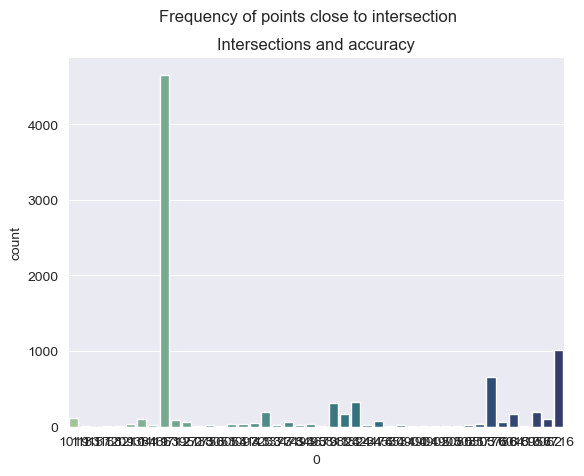

In [63]:
sns.barplot(x=0,y='count', data=road_sorted, palette='crest');
plt.suptitle('Frequency of points close to intersection')
plt.title('Intersections and accuracy')
#plt.savefig('delay_time.png')

In [64]:
if clipped_gdf.crs is None:
    # Only do this if you are sure coordinates are lon/lat!
    clipped_gdf = clipped_gdf.set_crs(epsg=4326)
roads = clipped_gdf.to_crs(epsg=3857)

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

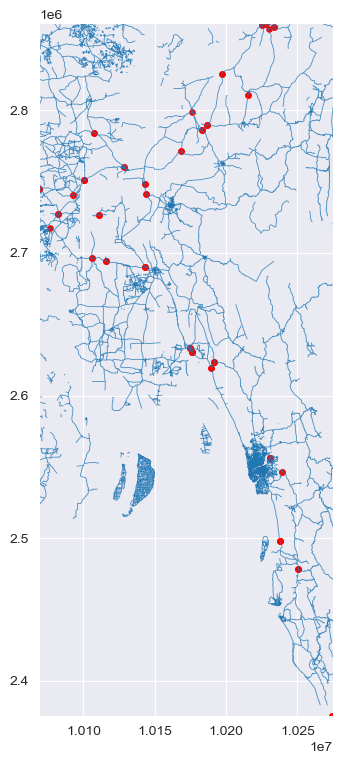

In [65]:
# Roads to Web Mercator
roads = clipped_gdf.to_crs(3857)

# Intersections -> GeoDataFrame in 3857
ints = gpd.GeoDataFrame(
    gdf_intersections,
    geometry=gpd.points_from_xy(gdf_intersections.lon, gdf_intersections.lat),
    crs=4326
).to_crs(3857)

# Tight bbox around intersections (+ padding in meters)
xmin, ymin, xmax, ymax = ints.total_bounds
pad = 250

ax = roads.plot(figsize=(9, 9), linewidth=0.6, alpha=0.8)
ints.plot(ax=ax, color='red', markersize=14)

ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)
ax.set_aspect('equal')

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs='EPSG:3857',
    zoom=19,
    reset_extent=True
)
plt.show()